Files already downloaded and verified
Files already downloaded and verified


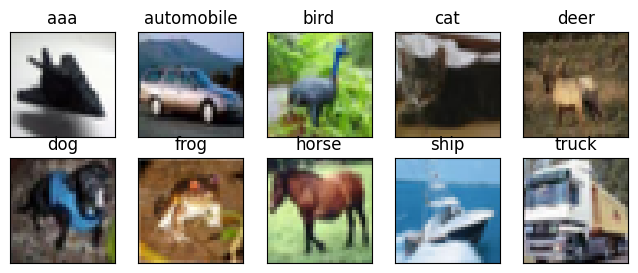

In [7]:
# 下载数据集

from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import datasets

# 设置打印张量时的格式选项,edgeitems：设置省略号处显示的边缘项数目。linewidth：设置每行的字符数，超过这个数时会换行。
torch.set_printoptions(edgeitems=2,linewidth=75)
torch.manual_seed(123)

data_path = '../data/cifar10'
cifar10 = datasets.CIFAR10(data_path,train=True,download=True)
cifar10_test = datasets.CIFAR10(data_path,train=False,download=True)

# 展示数据集

# 类别
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck'] #这里给每个类别定义了名字

# 创建图形窗口
fig = plt.figure(figsize=(8,3))
for i in range(10):
    # 添加子图
    ax = fig.add_subplot(2,5,1 + i, xticks=[],yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img,label in cifar10 if label == i)
    plt.imshow(img)

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


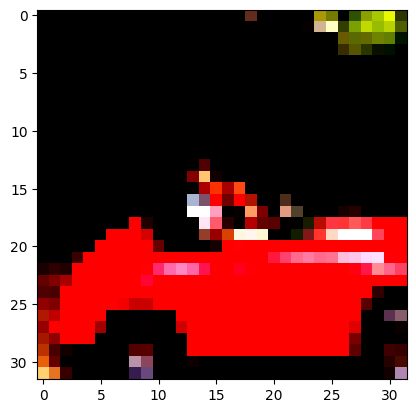

In [20]:
from torchvision import transforms

# to_tensor = transforms.ToTensor()
# img_t = to_tensor(img)

# tensor_cifar10 = datasets.CIFAR10(data_path,train=True,download=False,transform=transforms.ToTensor())


# # 数据标准化
# imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
# imgs.view(3,-1).mean(dim=1)
# imgs.view(3,-1).std(dim=1)
# 定义数据集的均值和标准差
mean = [0.4915, 0.4823, 0.4468]
std = [0.2470, 0.2435, 0.2616]
transformed_cifar10 = datasets.CIFAR10(
    data_path,train=True,download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

transformed_cifar10_test = datasets.CIFAR10(
    data_path,train=False,download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()







Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


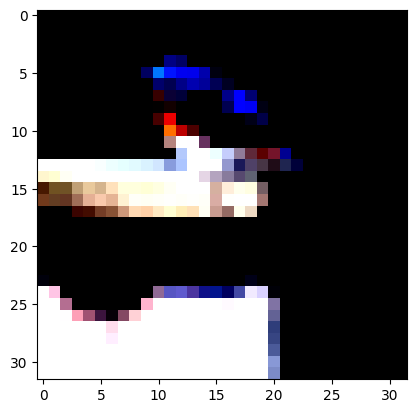

tensor([[-0.7621, -0.6287]], grad_fn=<LogSoftmaxBackward0>)

In [111]:
# 创建模型
label_map = {0:0,2:1}
class_names = ['airplane','bird']
cifar2 = [(img,label_map[label]) for img,label in transformed_cifar10 if label in [0,2]]
cifar2_test = [(img,label_map[label]) for img, label in transformed_cifar10_test if label in [0,2]]

import torch.nn as nn

n_out = 2

# 神经网络模型构建
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,n_out),
    nn.LogSoftmax(dim=1)
)
# 找个一鸟的图像
img,_=cifar2[1]
# 在处理图像数据时，不同的库对数据的存储顺序有不同的约定。
# 例如，PyTorch 中的图像数据通常按 (C, H, W) 的顺序存储，即通道 (Channels)，高度 (Height)，宽度 (Width)；而许多其他库（如 Matplotlib 或 OpenCV）则通常按 (H, W, C) 的顺序存储，即高度，宽度，通道。
# 为了在这些不同的库之间传递数据，有时需要重新排列 Tensor 的维度，这就是 permute 方法的用途。
plt.imshow(img.permute(1,2,0))
plt.show()

# 将图片放入模型中，查看概率结果
# view用于改变张量形状,-1将张量展平成一个一维张量
# unsqueeze用于在指定位置插入一个新的维度
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
out


In [66]:
# 设置设备
device = 'gpu'

In [ ]:
# 训练优化模型
import torch 
import torch.nn as nn
import torch.optim as optim


#使用DataLoader加载数据，设置shuffle表示打乱数据
train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=True)
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)
print(model)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for imgs,labels in train_loader:
        imgs = imgs.view(imgs.size(0),-1)
        out = model(imgs)
        loss = loss_fn(out,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss +=loss.item()
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")

    



In [ ]:
# 验证模型准确率
val_loader = torch.utils.data.DataLoader(cifar2_test, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        imgs = imgs.view(batch_size, -1)  # 展平图像
        outputs = model(imgs) #预测验证集数据
        
        _, predicted = torch.max(outputs, dim=1) #取较大值作为预测结果
        total += labels.size(0)#计算验证集的大小
        correct += (predicted == labels).sum().item() #计算预测正确的标签数量

print("Accuracy: ", correct / total)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


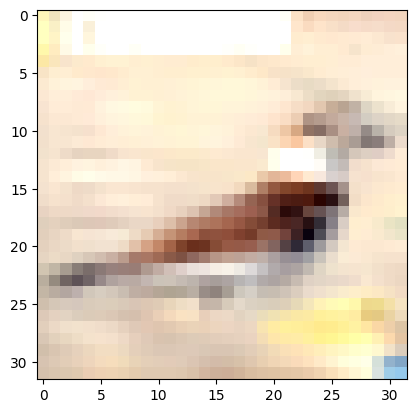

tensor([[0.5478, 0.4522]], grad_fn=<SoftmaxBackward0>)

In [171]:
import torch.nn.functional as F
# 获取一个批次的图像和标签
dataiter = iter(val_loader)
images, labels = next(dataiter)
# 反归一化图像以便于显示
def imshow(img):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 从 (C, H, W) 转换为 (H, W, C)
    plt.show()

index = 10
imshow(images[index])

img_batch = images[index].view(-1).unsqueeze(0)
out = model(img_batch)
# 应用 LogSoftmax
log_probs = F.log_softmax(out, dim=1)
# 可以通过 softmax 函数将 log_probs 转换为概率
probs = torch.softmax(log_probs, dim=1)
probs

